# Gaussian Processes

Gaussian Process model using the TensorFlow

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

### Data

,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,31,70,186,351,194,65,23,30,29,22,31,34,59,68,41,23,14,5,4
1,40,64,203,406,201,59,26,32,36,23,31,39,66,73,52,27,15,11,4
2,29,62,194,347,168,58,35,41,31,29,37,39,70,76,30,16,13,12,8
3,35,55,155,318,166,51,43,34,40,21,25,34,52,59,31,21,8,13,5
4,33,44,121,243,139,48,35,44,34,37,27,35,44,52,27,21,16,10,7


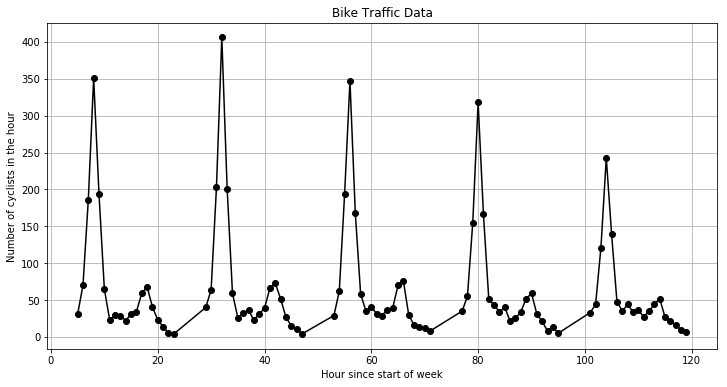

In [3]:
bike_data = pd.read_csv('traffic_data_week_2008_07_31.csv')
bike_data = bike_data.drop([5,6])
counts = bike_data.as_matrix().flatten()
times = np.zeros(bike_data.shape)
for n, r in bike_data.iterrows():
    times[n,:] = bike_data.columns.astype(np.float64) + (n*24)
times = times.flatten()

bike_counts = counts[:,np.newaxis]
bike_times = times[:,np.newaxis]

plt.figure(figsize=[12,6])
plt.plot(bike_times, bike_counts, 'ko-')
plt.grid(True)
plt.title('Bike Traffic Data')
plt.xlabel('Hour since start of week')
plt.ylabel('Number of cyclists in the hour')

bike_data

In [4]:
input_data = bike_times
output_data = bike_counts
input_values = np.linspace(np.min(input_data), np.max(input_data), 200)

#### TensorFlow dtype
Due to interations between the CPU and GPU, TensorFlow is quite strict about the difference between single and double precision floating point numbers (`tf.float32` and `tf.float64`) respectively. To be safe, when declaring constants and variables in TensorFlow I always specify the `dtype` parameter by using defining `dtype` and `dtype_convert` at the top of the file. This allows, for example:
```python
t_vector_of_ones = tf.ones(shape=[5], dtype=dtype)
t_correct_precision = dtype_convert(t_not_correct_precision)
```
If you get tensorflow errors about `tf.float32` and `tf.float64` you probably have a constant declared using the wrong `dtype` somewhere in the computational graph.

#### Inverting the covariance matrix
Covariance matrices should be symmetric and positive definite - this means that they can be inverted using the Cholesky decomposition $K = L L^{\mathtt{T}}$ where $L$ is a square, lower triangular matrix. There is a TensorFlow operation `t_L_matrix = tf.cholesky(t_K_matrix)` that returns the matrix $L$. 

Once you have the decomposed matrix, it is efficient to evaluation the matrix inversion $A = K^{-1} B$ using the special solve operation `t_A_matrix = tf.cholesky_solve(t_L_matrix, t_B_matrix)`. 

If you need to perform the operation $A = L^{-1} B$ there is also a special operation `t_A_matrix = tf.matrix_triangular_solve(t_L_matrix, t_B_matrix)`.

Because the cholesky decomposition requires a positive definite matrix, we often add a small "jitter" diagonal matrix to try to improve the nummerical stability (in case the eigenvalues of the kernel become close to zero). For example we would perform the following:
```python
jitter = 1.0e-8
t_L_matrix = tf.cholesky(t_K_matrix + jitter * tf.eye(tf.shape(t_K_matrix)[0], dtype=dtype)
```
where `tf.shape()[0]` is returning the size of the kernel matrix to build a diagonal matrix identity matrix using `tf.eye()` (and we note that we specify the `dtype` of the matrix).

In [5]:
dtype = tf.float64
dtype_convert = tf.to_double

# A wrapper function to create a real number variable (-infinity, infinity)
# with an initial value that will be optimised by tensorflow.
def create_real_variable(initial_value):
    return tf.Variable(initial_value, dtype=dtype)

# A wrapper function to create a positive variable (0, infinity) by
# taking the exp() of a real number - this will map the real range to
# the set of positive numbers.
def create_positive_variable(initial_value):
    assert initial_value > 0.0
    return tf.exp(tf.Variable(np.log(initial_value), dtype=dtype))

def print_hyperparameters(hyperparameter_dict, session):
    for (k, v) in hyperparameter_dict.items():
        print('{} = {:.6}'.format(k, session.run(v)))
    print('')

## Kernel
kernel cookbook:

https://www.cs.toronto.edu/~duvenaud/cookbook/

**The squared-exponential covariance kernel is defined as:**

$$
K(x_i, x_j) = \sigma_{\mathrm{f}}^{2} \exp\!\left(- \frac{1}{2l^2} \|x_i - x_j\|^2 \right)
$$


**The periodic kernel is defined as:**

$$
K(x_i, x_j) = \sigma_{\mathrm{f}}^{2} \exp\!\left( - 2 \gamma \left[\sin\left(\frac{\pi}{T} \sqrt{\|x_i - x_j\|^2} \right)\right]^2 \right)
$$

In [6]:
class Kernel:
    def __init__(self, kernel_type = 'squared exponential'):
        
        kernel_dict = {'squared exponential': (self.create_squared_exp_kernel, self.setup_squared_exp_kernel),
                       'periodic': (self.create_periodic_kernel, self.setup_periodic_kernel)}
        
        self.kernel = kernel_dict[kernel_type][0]
        self.setup = kernel_dict[kernel_type][1]
    
    def create_squared_exp_kernel(self, t_X1, t_X2, t_params):
        t_signal_variance = t_params[0]
        t_lengthscale = t_params[1]
        t_inv_lengthscale_squared = 1.0 / tf.square(t_lengthscale)
        x1x1 = t_inv_lengthscale_squared * tf.reduce_sum(t_X1 * t_X1, axis=1, keepdims=True)
        x2x2 = t_inv_lengthscale_squared * tf.reduce_sum(t_X2 * t_X2, axis=1, keepdims=True)
        dist_x1x2_sq = x1x1 + tf.transpose(x2x2) - 2.0 * t_inv_lengthscale_squared * tf.matmul(t_X1, 
                                                                                               t_X2, 
                                                                                               transpose_b=True)
        K = t_signal_variance * tf.exp(- 0.5 * dist_x1x2_sq)
        return K
    
    def setup_squared_exp_kernel(self, 
                                 initial_signal_variance = 1.0,
                                 initial_lengthscale = 1.0):
        t_signal_variance = create_positive_variable(initial_signal_variance)
        t_lengthscale = create_positive_variable(initial_lengthscale)
        # Add loose priors on the kernel hyperparameters
        t_hyper_prior = + 0.5 * tf.square(tf.log(t_signal_variance)) \
                        + 0.5 * tf.square(tf.log(t_lengthscale))
        hyperparameter_dict = {'signal_variance': t_signal_variance,
                               'lengthscale': t_lengthscale}
        return ((t_signal_variance, t_lengthscale), t_hyper_prior, hyperparameter_dict)
    
    def create_periodic_kernel(self, t_X1, t_X2, t_params):
        t_signal_variance = t_params[0]
        t_gamma = t_params[1]
        t_period = t_params[2]
        t_pi = tf.constant(np.pi, dtype=dtype)
        x1x1 = tf.reduce_sum(t_X1 * t_X1, axis=1, keepdims=True)
        x2x2 = tf.reduce_sum(t_X2 * t_X2, axis=1, keepdims=True)
        term1 = x1x1 + tf.transpose(x2x2) - 2 * tf.matmul(t_X1, t_X2, transpose_b=True)
        term2 = tf.sqrt(term1)
        term3 = -2 * t_gamma * tf.square(tf.sin((t_pi / t_period) * term2))
        K = t_signal_variance * tf.exp(term3)
        return K
    
    def setup_periodic_kernel(self,
                              initial_signal_variance = 1.0,
                              initial_gamma = 1.0,
                              initial_period = 24.0):
        t_signal_variance = create_positive_variable(initial_signal_variance)
        t_lengthscale = create_positive_variable(np.sqrt(1/initial_gamma))
        t_gamma = create_positive_variable(initial_gamma)
        t_period = create_positive_variable(initial_period)
        # Add loose priors on the kernel hyperparameters
        t_hyper_prior = + 0.5 * tf.square(tf.log(t_signal_variance)) \
                        + 0.5 * tf.square(tf.log(t_lengthscale)) 
        hyperparameter_dict = {'signal_variance': t_signal_variance,
                               'gamma': t_gamma,
                               'period': t_period}
        return ((t_signal_variance, t_gamma, t_period), t_hyper_prior, hyperparameter_dict)

## Gaussian Process with Gaussian Likelihood

In [7]:
class GP:
    def __init__(self, kernel_type = 'squared exponential',verbose = True):
        kernel = Kernel(kernel_type)
        self.kernel = kernel.kernel
        self.setup = kernel.setup
        self.verbose = verbose
        
        
    def fit(self, X, y, jitter = 1.0e-8, initial_sigma_noise_sq = 1.0, 
            learning_rate = 0.1, num_iterations = 2000):
        tf.reset_default_graph()
        
        self.X = X
        self.y = y
        # Constant training data in tensorflow
        t_X = tf.constant(X, dtype=dtype)
        t_Y = tf.constant(y, dtype=dtype)
        t_N = tf.shape(t_Y)[0]
        t_D = tf.shape(t_Y)[1]
        t_Q = tf.shape(t_X)[1]
        t_sigma_noise_sq = create_positive_variable(initial_sigma_noise_sq)
        t_params, t_hyper_prior, hyper_dict = self.setup()
        
        hyper_dict['sigma_noise_squared'] = t_sigma_noise_sq
        
        # create the training data covariance matrix + noise identity matrix
        # include the jitter term to improve nummerical stability
        t_K_xx = self.kernel(t_X, t_X, t_params) \
            + (t_sigma_noise_sq + jitter) * tf.eye(t_N, dtype=dtype)
        
        # Take the cholesky decomposition of K = L L^T to make it easy to calculate 
        # the inverse of K and the log determinant of K. This relies on K being a 
        # positive definite covariance matrix.
        t_L_xx = tf.cholesky(t_K_xx)

        # The log determinant of K is twice the sum of the log of the diagonal of the
        # cholesky matrix
        t_log_det = 2.0 * tf.reduce_sum(tf.log(tf.diag_part(t_L_xx)))

        # We can calculate the data fit term by using the cholesky matrix L to
        # invert the covariance matrix efficiently using the matrix triangular solve
        # operation. 
        #
        # Tr[K^-1 Y Y^T] = Tr[Y^T (L L^T)^-1 Y] = Tr[(Y^T L^-T) (L^-1 Y)] = sum((L^-1 Y)^2)
        #
        t_Kinv_YYtranspose = 0.5 * tf.reduce_sum(tf.square(tf.matrix_triangular_solve(t_L_xx, 
                                                                                      t_Y, 
                                                                                      lower=True)))

        # Add a loose prior on the noise variance
        t_noise_prior = + 0.5 * tf.square(tf.log(t_sigma_noise_sq))

        half_log_two_pi = tf.constant(0.5 * np.log(2.0 * np.pi), dtype=dtype)

        # Evaluate the NEGATIVE (since we will minimise) marginal log likelihood as
        # the objective for training the hyperparameters
        t_neg_log_likelihood = half_log_two_pi * dtype_convert(t_D) * dtype_convert(t_N) \
                             + 0.5 * dtype_convert(t_D) * t_log_det \
                             + t_Kinv_YYtranspose + t_hyper_prior + t_noise_prior
        
        t_objective = t_neg_log_likelihood
        
        with tf.Session() as session:
            optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(t_objective)
            session.run(tf.global_variables_initializer())
            
            if self.verbose:
                print('Before Optimisation:')
                print_hyperparameters(hyper_dict, session)
            
            refresh_iter = int(np.ceil(num_iterations / 10))
            for i in range(num_iterations):
                opt, cost = session.run((optimizer, t_objective))
                if self.verbose:
                    if (i % refresh_iter) == 0:
                        print('  opt iter {:5}: objective = {}'.format(i, cost))
            
            if self.verbose:
                print('Final iter {:5}: objective = {}\n'.format(i, cost))
                print('Before Optimisation:')
                print_hyperparameters(hyper_dict, session)
                
            self.t_L_xx = session.run(t_L_xx)
            self.t_params = session.run(t_params)
            self.t_sigma_noise_sq = session.run(t_sigma_noise_sq)
      
    
    def predict(self, input_values):
        tf.reset_default_graph()
        # Constant training data in tensorflow
        t_L_xx =  tf.constant(self.t_L_xx, dtype=dtype)
        t_params =  tf.constant(self.t_params, dtype=dtype)
        t_sigma_noise_sq = tf.constant(self.t_sigma_noise_sq, dtype=dtype)
        t_X = tf.constant(self.X, dtype=dtype)
        t_Y = tf.constant(self.y, dtype=dtype)
        # Ensure N* x 1 input variable
        if input_values.ndim == 1:
            input_values = input_values[:,np.newaxis]
        tf_input = tf.constant(input_values, dtype=dtype)
        
        # Invert using the cholesky decomposition of the kernel
        t_Kinv_Y = tf.cholesky_solve(t_L_xx, t_Y)
        
        # Calculate the kernel from the input to the training data
        t_K_x_X = self.kernel(tf_input, t_X, t_params)
        
        # Get the predicitive mean
        t_y_mean = tf.matmul(t_K_x_X, t_Kinv_Y)
        
        t_K_x_x_diag = tf.diag_part(self.kernel(tf_input, tf_input, t_params)) \
            + t_sigma_noise_sq * tf.ones([tf.shape(tf_input)[0]], dtype=dtype)

        # Get the predicitve variance
        t_y_var = t_K_x_x_diag - tf.reduce_sum(tf.square(tf.matrix_triangular_solve(t_L_xx, 
                                                                                    tf.transpose(t_K_x_X))), 
                                               axis=0)

        # Make sure a N* x 1 matrix (where N* = number of test inputs)
        t_y_var = t_y_var[:, tf.newaxis]

        # Return the predicitve mean and variance
        with tf.Session() as session:
            session.run(tf.global_variables_initializer())
            pred_mean, pred_var = session.run((t_y_mean, t_y_var))
            
        return pred_mean, pred_var

###  Demo: Squared-Exponential Covariance Kernel

Before Optimisation:
signal_variance = 1.0
lengthscale = 1.0
sigma_noise_squared = 1.0

  opt iter     0: objective = 170865.7284377394
  opt iter   200: objective = 1974.7006453600045
  opt iter   400: objective = 1002.7616672496886
  opt iter   600: objective = 769.0917894565972
  opt iter   800: objective = 687.3504092834789
  opt iter  1000: objective = 653.801730162252
  opt iter  1200: objective = 638.9149470729735
  opt iter  1400: objective = 632.0909944106746
  opt iter  1600: objective = 628.957637808625
  opt iter  1800: objective = 627.5484481436587
Final iter  1999: objective = 626.9384260486804

Before Optimisation:
signal_variance = 162.428
lengthscale = 4.22954
sigma_noise_squared = 6687.03



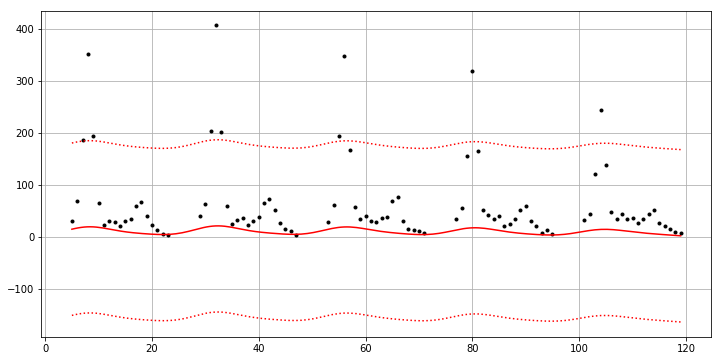

In [8]:
gp = GP(kernel_type = 'squared exponential', verbose = True)

gp.fit(input_data, output_data, jitter = 1.0e-8, initial_sigma_noise_sq = 1.0, 
       learning_rate = 0.1, num_iterations = 2000)

pred_mean, pred_var = gp.predict(input_values)


plt.figure(figsize=[12,6])
plt.plot(input_data, output_data, 'k.')
plt.plot(input_values, pred_mean, 'r-')
plt.plot(input_values, pred_mean + 2.0 * np.sqrt(pred_var), 'r:')
plt.plot(input_values, pred_mean - 2.0 * np.sqrt(pred_var), 'r:')
plt.grid(True)

### Demo: Periodic Kernel

Before Optimisation:
signal_variance = 1.0
gamma = 1.0
period = 24.0
sigma_noise_squared = 1.0

  opt iter     0: objective = 136405.73566419652
  opt iter   200: objective = 1248.6197379094979
  opt iter   400: objective = 853.1950298910485
  opt iter   600: objective = 693.3479548617366
  opt iter   800: objective = 612.8550618549133
  opt iter  1000: objective = 568.3171673236532
  opt iter  1200: objective = 542.1519676414471
  opt iter  1400: objective = 526.1513969031049
  opt iter  1600: objective = 516.1081350616977
  opt iter  1800: objective = 509.7075331815085
Final iter  1999: objective = 505.61891306117127

Before Optimisation:
signal_variance = 3292.86
gamma = 14.8995
period = 24.0078
sigma_noise_squared = 166.304



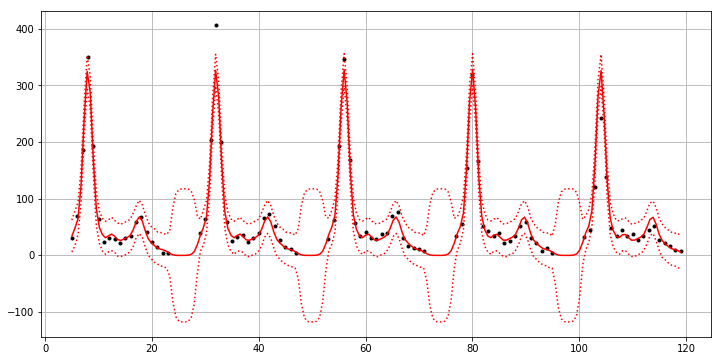

In [9]:
gp = GP(kernel_type = 'periodic', verbose = True)

gp.fit(input_data, output_data, jitter = 1.0e-8, initial_sigma_noise_sq = 1.0, 
       learning_rate = 0.1, num_iterations = 2000)

pred_mean, pred_var = gp.predict(input_values)


plt.figure(figsize=[12,6])
plt.plot(input_data, output_data, 'k.')
plt.plot(input_values, pred_mean, 'r-')
plt.plot(input_values, pred_mean + 2.0 * np.sqrt(pred_var), 'r:')
plt.plot(input_values, pred_mean - 2.0 * np.sqrt(pred_var), 'r:')
plt.grid(True)

## Gaussian Process with Poisson Likelihood

The Poisson distribution is a probability distribution over counts within a fixed time period (positive integer values). The likelihood function is defined in terms of a positive rate parameter $\lambda > 0$ as

$$
p(y) = \frac{\lambda^{y} \exp(-\lambda)}{y!}, \; y \in [0,1,2,3,\dots]
$$

In a similar manner to the GP for binary classification (Bernoulli likelihood) in the lecture notes, we can define a GP with a Poisson likelihood

$$
p(Y, f \mid X, \theta) = p(Y \mid f) \, p(f \mid X, \theta)
$$

where the $\lambda$ parameter in the Poisson likelihood is a function of $f$. Assuming iid data we have

$$
p(Y \mid X) = \prod_{n=1}^{N} \frac{{\lambda(f_n)}^{y_n} \exp(-\lambda(f_n))}{y_n!}
$$

We put a GP prior over $f$

$$
p(f \mid X, \theta) = \mathcal{N}(f \mid 0, \kappa(X,X;\theta)
$$

however this makes the value of $f$ a real number. We map this to a positive number through the exponential function such that

$$
\lambda(f_n) = \exp(f_n) \; \Rightarrow \; \lambda(f_n) \in \mathcal{R}^{+} 
$$

To calculate the marginal log likelihood we must integrate out the function parameters $f$ such that

$$
\log p(Y \mid X, \theta) = \log \int p(Y \mid f) \, p(f \mid X, \theta) \mathrm{d}f
$$

As for the classification GP, we cannot perform this operation in closed form so we use a variational approximation 

$$
q(f) = \prod_n \mathcal{N}(f_n \mid \mu_n, \sigma^2)
$$

with a mean variational parameter $\mu_n$ for each $f_n$ and a shared variance $\sigma^2$.

The variational lower bound can then be defined as 

$$
\mathcal{L} =  \sum_n \mathbb{E}_{q(f_n)}\!\left[ \log p(y_n \mid f_n) \right] - \mathrm{KL}\big[ q(f) \,\|\, p(f\mid X, \theta) \big]
$$

We now look at the two terms in the lower bound and the next task is to derive expressions related to the expectation and the KL divergence.

the KL divergence between two **univariate** Gaussian distributions:
    
$$
\mathrm{KL}\left[\mathcal{N}(x \mid \mu_0, \sigma_0^2) \| \mathcal{N}(x \mid \mu_1, \sigma_1^2) \right] =
\int \mathcal{N}(x \mid \mu_0, \sigma_0^2) \log \frac{\mathcal{N}(x \mid \mu_0, \sigma_0^2)}{\mathcal{N}(x \mid \mu_1, \sigma_1^2)} \mathrm{d}x
$$

The corresponding KL divergence for **multivariate** Gaussians is given by

$$
\mathrm{KL}\left[\mathcal{N}(x \mid \mu_0, \Sigma_0) \| \mathcal{N}(x \mid \mu_1, \Sigma_1) \right] = 
\frac{1}{2} \left( \mathrm{Tr}[\Sigma_1^{-1} \Sigma_0] + (\mu_1 - \mu_0)^{T}\Sigma_1^{-1}(\mu_1 - \mu_0) - N + \log \frac{\det \Sigma_1}{\det \Sigma_0} \right), \;\text{for}\; x \in \mathbb{R}^{N}
$$

The following expression is the KL divergence between the approximating distrbution and our Gaussian process prior on $f$

$$
\mathrm{KL}\left[ q(f) \| p(f\mid X, \theta) \right] = \frac{1}{2} \left( \mathrm{Tr}[K^{-1}(\sigma^2 I + \mu \mu^T)] - N + \log \det K - N \log{\sigma^2} \right), \; K = \kappa(X,X;\theta)
$$



The expectation expression can be decomposed into a sum over each $f_n \sim \mathcal{N}(\mu_n, \sigma^2)$. 

The following expression is the expectation of the log likelihood of the Poisson distribution wrt $q(f_n)$:

$$
\mathbb{E}_{q(f_n)}\!\left[ \log p(y_n \mid f_n) \right] = y_n \mu_n - \exp\left( \frac{2\mu_n + \sigma^2}{2} \right) - \log(y_n!)
$$

Note: for the lower bound we can ignore the $\log(y_n!)$ term since it is constant wrt the hyperparameters and variational parameters.



### The Lower Bound for the Poisson GP

The final lower bound for the Poisson GP is therefore given by
$$
\mathcal{L} =  \sum_n \left\{ y_n \mu_n - \exp\left(\frac{2\mu_n + \sigma_n^2}{2} \right) - \log(y_n!) \right\} 
- \frac{1}{2} \left( \mathrm{Tr}[K^{-1}(\Sigma_n + \mu \mu^T)] - N + \log \det K - \sum_n \log{\sigma_n^2} \right) $$

$$
\mathcal{L} =  \sum_n \left\{ y_n \mu_n - \exp\left(\frac{2\mu_n + \sigma_n^2}{2} \right) - \log(y_n!) \right\} 
- \frac{1}{2} \left( \mathrm{Tr}[K^{-1}(\sigma^2 I + \mu \mu^T)] - N + \log \det K - N \log{\sigma^2} \right) 
$$

Update the GP code from above to optimise the negative lower bound of the Poisson GP. Have to introduce extra TensorFlow variables for the variational parameters $\{\mu_n\}$ and $\sigma^2$. Initialise the means as $\mu_n = \log(y_n)$ and the variance $\sigma^2 = 1$.

**IMPORTANT: Also need to update the predictive posterior. For the purposes of plotting the result it is sufficent to evaluate the mean of $f^{*}$ and plot $\lambda(\mu_f^{*}) = \exp(\mu_{f}^{*})$ against the training data since $\lambda$ is the mean of a Poisson distribution. Also need to derive the updated term for the predicive variance of $f^{*}$ and plot the error bars of the prediction as 
$\exp\left(\mu_f^{*} \pm 2 \sqrt{\sigma_f^{*2}}\right)$
which means put np.exp() in the y of plot function**

In [10]:
class Poisson_GP:
    def __init__(self, kernel_type = 'squared exponential',verbose = True):
        kernel = Kernel(kernel_type)
        self.kernel = kernel.kernel
        self.setup = kernel.setup
        self.verbose = verbose
        
        
    def fit(self, X, y, 
            jitter = 1.0e-8, 
            initial_sigma_noise_sq = 1.0, 
            initial_Sigma_N = 1.0,
            learning_rate = 0.1, 
            num_iterations = 2000):
        
        tf.reset_default_graph()
        
        self.X = X
        self.y = y
        # Constant training data in tensorflow
        t_X = tf.constant(X, dtype=dtype)
        t_Y = tf.constant(y, dtype=dtype)
        t_N = tf.shape(t_Y)[0]
        t_D = tf.shape(t_Y)[1]
        t_Q = tf.shape(t_X)[1]
        t_sigma_noise_sq = create_positive_variable(initial_sigma_noise_sq)
        t_Sigma_N = create_positive_variable(initial_Sigma_N)
        
        t_params, t_hyper_prior, hyper_dict = self.setup()
        
        t_Mu_N = create_real_variable(np.log(y))
        
        hyper_dict['sigma_noise_squared'] = t_sigma_noise_sq
        hyper_dict['Sigma_N'] = t_Sigma_N
        
        # create the training data covariance matrix + noise identity matrix
        # include the jitter term to improve nummerical stability
        t_K_xx = self.kernel(t_X, t_X, t_params) \
            + (t_sigma_noise_sq + jitter) * tf.eye(t_N, dtype=dtype)
            
        t_K_xx_inv = tf.matrix_inverse(t_K_xx)
        
        # Take the cholesky decomposition of K = L L^T to make it easy to calculate 
        # the inverse of K and the log determinant of K. This relies on K being a 
        # positive definite covariance matrix.
        t_L_xx = tf.cholesky(t_K_xx)

        # The log determinant of K is twice the sum of the log of the diagonal of the
        # cholesky matrix
        t_log_det = 2.0 * tf.reduce_sum(tf.log(tf.diag_part(t_L_xx)))
        
        # Get log likelihood for the poisson distribution
        t_log_likelihood = tf.reduce_sum(tf.matmul(t_Y, t_Mu_N, transpose_a = True)) \
                - tf.reduce_sum(tf.exp((2 * t_Mu_N + t_Sigma_N) / 2))

        # Get KL divergence
        t_small_bracket = t_Sigma_N * tf.eye(t_N, dtype=dtype) + tf.matmul(t_Mu_N, t_Mu_N, transpose_b = True)
    
        t_KL = 0.5*(tf.trace(tf.matmul(t_K_xx_inv, t_small_bracket)) - dtype_convert(t_N) + t_log_det \
                - dtype_convert(t_N) * tf.log(t_Sigma_N))
    
        # Get lower bound
        lower_bound = t_log_likelihood - t_KL
    
        # Get neg log likelihood used of optimize
        t_neg_log_likelihood = - lower_bound
        
        t_objective = t_neg_log_likelihood
        
        with tf.Session() as session:
            optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(t_objective)
            session.run(tf.global_variables_initializer())
            
            if self.verbose:
                print('Before Optimisation:')
                print_hyperparameters(hyper_dict, session)
            
            refresh_iter = int(np.ceil(num_iterations / 10))
            for i in range(num_iterations):
                opt, cost = session.run((optimizer, t_objective))
                if self.verbose:
                    if (i % refresh_iter) == 0:
                        print('  opt iter {:5}: objective = {}'.format(i, cost))
            
            if self.verbose:
                print('Final iter {:5}: objective = {}\n'.format(i, cost))
                print('Before Optimisation:')
                print_hyperparameters(hyper_dict, session)
                
            self.t_L_xx = session.run(t_L_xx)
            self.t_params = session.run(t_params)
            self.t_sigma_noise_sq = session.run(t_sigma_noise_sq)
            self.t_Mu_N = session.run(t_Mu_N)
      
    
    def predict(self, input_values):
        tf.reset_default_graph()
        # Constant training data in tensorflow
        t_L_xx =  tf.constant(self.t_L_xx, dtype=dtype)
        t_params =  tf.constant(self.t_params, dtype=dtype)
        t_sigma_noise_sq = tf.constant(self.t_sigma_noise_sq, dtype=dtype)
        t_Mu_N = tf.constant(self.t_Mu_N, dtype=dtype)
        
        t_X = tf.constant(self.X, dtype=dtype)
        t_Y = tf.constant(self.y, dtype=dtype)
        
        # Ensure N* x 1 input variable
        if input_values.ndim == 1:
            input_values = input_values[:,np.newaxis]
        tf_input = tf.constant(input_values, dtype=dtype)
        
        # Invert using the cholesky decomposition of the kernel
        t_Kinv_Y = tf.cholesky_solve(t_L_xx, t_Mu_N)
        
        # Calculate the kernel from the input to the training data
        t_K_x_X = self.kernel(tf_input, t_X, t_params)
        
        # Get the predicitive mean
        t_y_mean = tf.matmul(t_K_x_X, t_Kinv_Y)
        
        t_K_x_x_diag = tf.diag_part(self.kernel(tf_input, tf_input, t_params)) \
            + t_sigma_noise_sq * tf.ones([tf.shape(tf_input)[0]], dtype=dtype)

        # Get the predicitve variance
        t_y_var = t_K_x_x_diag - tf.reduce_sum(tf.square(tf.matrix_triangular_solve(t_L_xx, 
                                                                                    tf.transpose(t_K_x_X))), 
                                               axis=0)

        # Make sure a N* x 1 matrix (where N* = number of test inputs)
        t_y_var = t_y_var[:, tf.newaxis]

        # Return the predicitve mean and variance
        with tf.Session() as session:
            session.run(tf.global_variables_initializer())
            pred_mean, pred_var = session.run((t_y_mean, t_y_var))
            
        return pred_mean, pred_var

### Demo: Squared-Exponential Covariance Kernel

**IMPORTANT: Also need to update the predictive posterior. For the purposes of plotting the result it is sufficent to evaluate the mean of $f^{*}$ and plot $\lambda(\mu_f^{*}) = \exp(\mu_{f}^{*})$ against the training data since $\lambda$ is the mean of a Poisson distribution. Also need to derive the updated term for the predicive variance of $f^{*}$ and plot the error bars of the prediction as 
$\exp\left(\mu_f^{*} \pm 2 \sqrt{\sigma_f^{*2}}\right)$
which means put np.exp() in the y of plot function**

Before Optimisation:
signal_variance = 1.0
lengthscale = 1.0
sigma_noise_squared = 1.0
Sigma_N = 1.0

  opt iter     0: objective = -18478.26615329585
  opt iter   200: objective = -22477.732060897473
  opt iter   400: objective = -22480.769921861367
  opt iter   600: objective = -22480.797064876766
  opt iter   800: objective = -22480.797122696436
  opt iter  1000: objective = -22480.79712271463
  opt iter  1200: objective = -22480.797122714634
  opt iter  1400: objective = -22480.79712271461
  opt iter  1600: objective = -22480.797122714586
  opt iter  1800: objective = -22480.797122714626
Final iter  1999: objective = -22480.7971227146

Before Optimisation:
signal_variance = 9.4511
lengthscale = 4.28425
sigma_noise_squared = 0.0806661
Sigma_N = 0.0136773



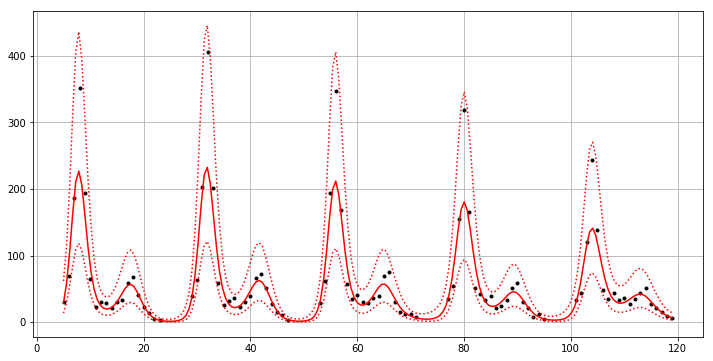

In [11]:
gp = Poisson_GP(kernel_type = 'squared exponential', verbose = True)

gp.fit(input_data, output_data, jitter = 1.0e-8, initial_sigma_noise_sq = 1.0, initial_Sigma_N = 1.0, 
       learning_rate = 0.1, num_iterations = 2000)

pred_mean, pred_var = gp.predict(input_values)


plt.figure(figsize=[12,6])
plt.plot(input_data, output_data, 'k.')
plt.plot(input_values, np.exp(pred_mean), 'r-')
plt.plot(input_values, np.exp(pred_mean + 2.0 * np.sqrt(pred_var)), 'r:')
plt.plot(input_values, np.exp(pred_mean - 2.0 * np.sqrt(pred_var)), 'r:')
plt.grid(True)

### Demo: Periodic Kernel

**IMPORTANT: Also need to update the predictive posterior. For the purposes of plotting the result it is sufficent to evaluate the mean of $f^{*}$ and plot $\lambda(\mu_f^{*}) = \exp(\mu_{f}^{*})$ against the training data since $\lambda$ is the mean of a Poisson distribution. Also need to derive the updated term for the predicive variance of $f^{*}$ and plot the error bars of the prediction as 
$\exp\left(\mu_f^{*} \pm 2 \sqrt{\sigma_f^{*2}}\right)$
which means put np.exp() in the y of plot function**

Before Optimisation:
signal_variance = 1.0
gamma = 1.0
period = 24.0
sigma_noise_squared = 1.0
Sigma_N = 1.0

  opt iter     0: objective = -18661.565653605972
  opt iter   200: objective = -22555.5197863872
  opt iter   400: objective = -22545.97889599836
  opt iter   600: objective = -22566.47558474265
  opt iter   800: objective = -22569.068466403463
  opt iter  1000: objective = -22543.60549876464
  opt iter  1200: objective = -22572.136953722802
  opt iter  1400: objective = -22573.185581336536
  opt iter  1600: objective = -22574.616438400735
  opt iter  1800: objective = -22552.138105299928
Final iter  1999: objective = -22567.10389058831

Before Optimisation:
signal_variance = 7.82177
gamma = 1.95389
period = 24.0818
sigma_noise_squared = 0.0382172
Sigma_N = 0.00999288



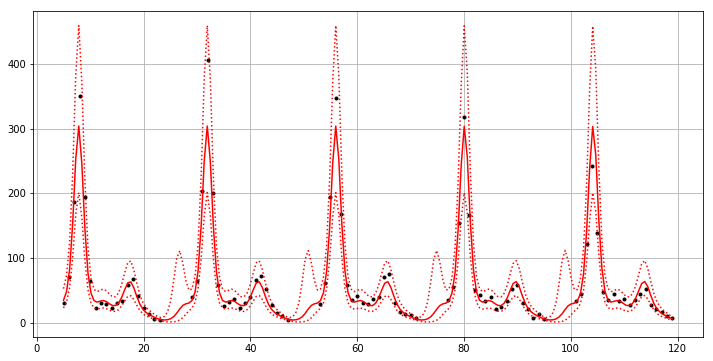

In [12]:
gp = Poisson_GP(kernel_type = 'periodic', verbose = True)

gp.fit(input_data, output_data, jitter = 1.0e-8, initial_sigma_noise_sq = 1.0, initial_Sigma_N = 1.0, 
       learning_rate = 0.1, num_iterations = 2000)

pred_mean, pred_var = gp.predict(input_values)


plt.figure(figsize=[12,6])
plt.plot(input_data, output_data, 'k.')
plt.plot(input_values, np.exp(pred_mean), 'r-')
plt.plot(input_values, np.exp(pred_mean + 2.0 * np.sqrt(pred_var)), 'r:')
plt.plot(input_values, np.exp(pred_mean - 2.0 * np.sqrt(pred_var)), 'r:')
plt.grid(True)